In [21]:
# Importar dependencias
!pip install tensorflow_datasets
!sudo apt-get install graphviz && pip3 install graphviz
!pip install keras_visualizer
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import os
import math
import random
from keras_visualizer import visualizer

     |████████████████████████████████| 46 kB 1.8 MB/s             


In [8]:
# Cargar tensorboard
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Para entrenar al modelo vamos a utilizar un set de datos que viene incluido en Tensorflow, los detalles se pueden encontrar en la página [https://laurencemoroney.com/datasets.html#rock-paper-scissors-dataset](https://laurencemoroney.com/datasets.html#rock-paper-scissors-dataset)

Así, vamos a descargarlo

In [9]:
DATASET_NAME = 'rock_paper_scissors'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

Vamos a explorar como es esta dataset:

In [10]:
print("Tamaño test de datos de entrenamiento: ", len(list(dataset_train_raw)))
print("Tamaño test de datos de prueba: ", len(list(dataset_test_raw)))

print("Tamaño de las imágenes: ", dataset_info.features['image'].shape)
print("Labels/Etiquetas (lo que queremos predecir): ", )
print(" - ", dataset_info.features['label'].int2str(0))
print(" - ", dataset_info.features['label'].int2str(1))
print(" - ", dataset_info.features['label'].int2str(2))

Tamaño test de datos de entrenamiento:  2520
Tamaño test de datos de prueba:  372
Tamaño de las imágenes:  (300, 300, 3)
Labels/Etiquetas (lo que queremos predecir): 
 -  rock
 -  paper
 -  scissors


¿Cómo son estas imágenes?

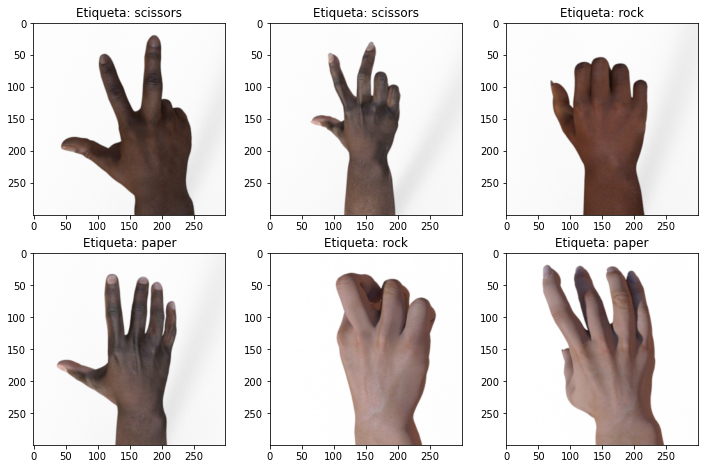

In [12]:
plt.figure(figsize=(12, 12))
indice = 0
ejemplos = dataset_train_raw.take(6)
for e in ejemplos:
    imagenn, etiqueta = e
    indice += 1
    plt.subplot(3,3, indice)
    plt.title("Etiqueta: " + dataset_info.features['label'].int2str(etiqueta.numpy()))
    plt.imshow(imagenn.numpy())


# Pre-procesamiento
Ahora que sabemos como son estas imagennes, vamos a optimizar estos datos para la red neuronal

In [13]:
def aplicar_formato(imagen, etiqueta):
    # Hago que el color sea un número entre 0 y 1.
    imagen = tf.cast(imagen, tf.float32) / 255
    # Cambio su tamaño a uno más pequeño
    imagen = tf.image.resize(imagen, [150, 150])
    return imagen, etiqueta

In [14]:
dataset_train = dataset_train_raw.map(aplicar_formato)
dataset_test = dataset_test_raw.map(aplicar_formato)

Ahora que unificamos el formato, vamos a aplicar distintos cambios aleatorios a las imagenes para prevenir el overfitting

In [15]:
# Funciones para cambiar aleatoriamente
def rotar(imagen: tf.Tensor) -> tf.Tensor:
    imagen = tf.image.random_flip_left_right(imagen)
    imagen = tf.image.random_flip_up_down(imagen)
    return imagen

def cambiar_color(imagen: tf.Tensor) -> tf.Tensor:
    imagen = tf.image.random_hue(imagen, max_delta=0.08)
    imagen = tf.image.random_saturation(imagen, lower=0.7, upper=1.3)
    imagen = tf.image.random_brightness(imagen, 0.05)
    imagen = tf.image.random_contrast(imagen, lower=0.8, upper=1)
    imagen = tf.clip_by_value(imagen, clip_value_min=0, clip_value_max=1)
    return imagen

def rotar2(imagen: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        imagen,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )

def invertir(imagen: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        imagen = tf.math.multiply(imagen, -1)
        imagen = tf.math.add(imagen, 1)
    return imagen

def ampliar(imagen: tf.Tensor, min_zoom=0.8, max_zoom=1.0) -> tf.Tensor:
    imagen_width, imagen_height, imagen_colors = imagen.shape
    crop_size = (imagen_width, imagen_height)

    # Generate crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(min_zoom, max_zoom, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an imagen
        crops = tf.image.crop_and_resize(
            [img],
            boxes=boxes,
            box_indices=np.zeros(len(scales)),
            crop_size=crop_size
        )
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: imagen, lambda: random_crop(imagen))

def mejorar_datos(imagen, label):
    imagen = rotar(imagen)
    imagen = cambiar_color(imagen)
    imagen = rotar2(imagen)
    imagen = ampliar(imagen)
    imagen = invertir(imagen)
    return imagen, label

In [16]:
dataset_train_augmented = dataset_train.map(mejorar_datos)

Volvemos a mostrar las imagenes, las de prueba quedan igual



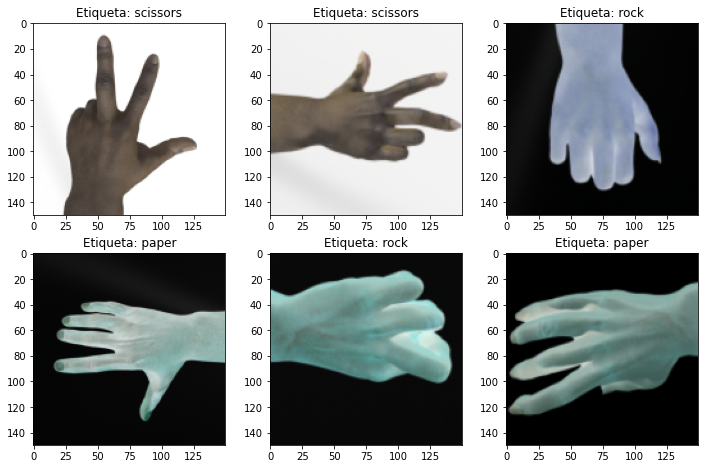

In [17]:
plt.figure(figsize=(12, 12))
indice = 0
ejemplos = dataset_train_augmented.take(6)
for e in ejemplos:
    imagenn, etiqueta = e
    indice += 1
    plt.subplot(3,3, indice)
    plt.title("Etiqueta: " + dataset_info.features['label'].int2str(etiqueta.numpy()))
    plt.imshow(imagenn.numpy())

Desordenamos los datos, para que la red no aprenda del orden de las imagenes.

In [18]:
TAMANIO = 32
dataset_train_augmented_shuffled = dataset_train_augmented\
    .shuffle(buffer_size=len(list(dataset_train_augmented)))\
    .batch(TAMANIO)\
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

dataset_test_shuffled = dataset_test.batch(TAMANIO)

# Creamos el modelo y lo entrenamos

In [19]:
model = tf.keras.models.Sequential()

# First convolution.
model.add(tf.keras.layers.Convolution2D(
    input_shape=(150, 150, 3),
    filters=64,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

# Second convolution.
model.add(tf.keras.layers.Convolution2D(
    filters=64,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

# Third convolution.
model.add(tf.keras.layers.Convolution2D(
    filters=128,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

# Fourth convolution.
model.add(tf.keras.layers.Convolution2D(
    filters=128,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

# Flatten the results to feed into dense layers.
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))

# 512 neuron dense layer.
model.add(tf.keras.layers.Dense(
    units=512,
    activation=tf.keras.activations.relu
))

# Output layer.
model.add(tf.keras.layers.Dense(
    units=3,
    activation=tf.keras.activations.softmax
))

Guardamos una representación del modelo en la imagen "graph.png"

In [23]:
visualizer(model, format='png', view=False)

ValueError: Keras Visualizer: Error while visualizing

In [ ]:
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(
    optimizer=rmsprop_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

steps_per_epoch = len(list(dataset_train_augmented)) // TAMANIO
validation_steps = len(list(dataset_test_shuffled)) // TAMANIO

model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

In [ ]:
train_loss, train_accuracy = model.evaluate(
    x=dataset_train.batch(TAMANIO).take(len(list(dataset_train_augmented)) )
)

test_loss, test_accuracy = model.evaluate(
    x=dataset_test.batch(TAMANIO).take(len(list(dataset_test_shuffled)))
)

print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)
print('\n')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

In [ ]:
model_name = 'rock_paper_scissors_cnn.h5'
model.save(model_name, save_format='h5')

In [ ]:
model_cargado = tf.keras.models.load_model('./rock_paper_scissors_cnn.h5')
